In [153]:
# Libraries used
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb

train_df = pd.read_csv("/home/druglord/Documents/ML/Competetion/house-prices-advanced-regression-techniques/train.csv")
# train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [2]:
# Steps to follow
# 1. Remove outliers
#       1.1. Using Query
#       1.2. Use mean/median points
#       1.3. Use pyplots to look for outliers
#       1.4. Use zscore for outliers(4+ are outliers)
#       1.5. Handling missing values
#       1.6. Remove outliers
# 2. Handling missing values
# 3. Use median to replace value instead of mean
# 4. Remove Z score greater than 4, 5, 7, 8
# 5. Feature Engineering
#       5.1. One hot encoding
#       5.2. Binning => Group continuous data into bins
#       5.3. Polynomial Features
#       5.4. Feature Scaling
#       5.5. Log Transform
#       5.6. Target Encoding
#       5.7. Frequency encoding
#       5.8. Data bucketizing
#       5.9. Normalize
#       5.10. Feature Crossing
#       5.11. Principal Component Analysis
# 6. Neural Network gives better results?

In [230]:
# Removing outliers
# 1.1 Using Query
outliers_q = train_df.query("SalePrice > 600000" and "LotArea > 60000")


# 1.2 Using mean/median value point
#       1.2.1 Normal Distribution
# Below => mean - 3 * (sigma)
# Above => mean + 3 * (sigma)
#       1.2.3 Skewed Distribution
# Below => q1 - 1.5 * iqr
# Above => q3 + 1.5 * iqr
arg = "SalePrice"
q1 = train_df[arg].quantile(0)
q3 = train_df[arg].quantile(.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr
# Mean/median outlier 
outliers_m = train_df[(train_df[arg] < low) | (train_df[arg] > up)]


# 1.3 Using scatter plots
# plt.scatter(x = "SalePrice", y = "YrSold", data = train_df)

# 1.4. Using zscore
outliers_z_t = stats.zscore(train_df["SalePrice"]).sort_values().head(10)

# 1.5 Remove the outliers
ids = [54, 198, 225, 232, 250, 279, 314, 336, 385, 441, 452, 458, 478, 497, 524, 662, 679, 692, 707, 770, 804, 849, 899, 935, 1025, 1047, 1128, 1170, 1183, 1299, 1374, 1397]
# Filter the rows based on the IDs
new_df = train_df.loc[train_df['Id'].isin(ids)]
train_df_filtered = train_df[~train_df['Id'].isin(new_df['Id'])]
train_df_filtered
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(10))

# train_df = train_df[train_df.Id.isin(outliers_q.index.tolist()) == False]


Outliers using query
[179, 441, 692, 770, 804, 899, 1047, 1170, 1183]
Outliers using mean/median
[54, 172, 250, 272, 314, 336, 385, 412, 452, 458, 524, 530, 662, 707, 770, 849, 1170, 1185, 1191, 1288, 1299, 1397]
Sale price zscore with train_df raw
[384, 457, 769, 1396, 1298, 451, 706, 249, 335, 313]


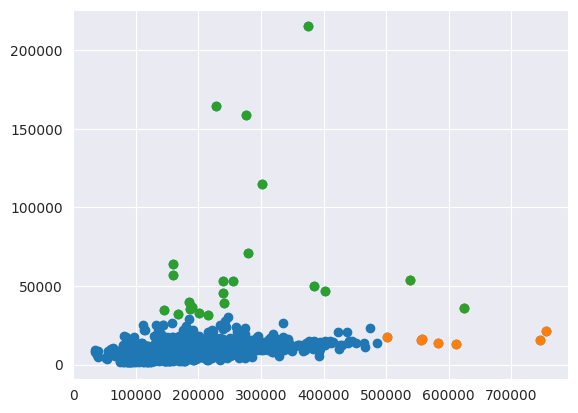

In [47]:
print("Outliers using query")
print(outliers_q["Id"].tolist())

print("Outliers using mean/median")
# gg = outliers_m["Id"].tolist()
print(outliers_m["Id"].tolist())
print("Sale price zscore with train_df raw")
# gg = outliers_z_t.index.tolist()
print(outliers_z_t.index.tolist())

outliers_z = train_df.loc[train_df['Id'].isin(outliers_z_t.index.tolist())]
# gg = train_df.loc[listt]

plt.scatter(x = "SalePrice", y = "LotArea", data = train_df, label = "train")
plt.scatter(x = "SalePrice", y = "LotArea", data = outliers_q, label = "q")
plt.scatter(x = "SalePrice", y = "LotArea", data = outliers_m, label = "m")
# plt.scatter(x = "SalePrice", y = "LotArea", data = outliers_z)

# outliers_z

In [154]:
def analyze_outliers(saleprice, arg, quan_1, quan_3):
    # Define your conditions
    outliers_q = train_df.query("SalePrice > 600000" or "2ndFlrSF > 1000")    
    q1 = train_df[arg].quantile(quan_1)
    q3 = train_df[arg].quantile(quan_3)
    iqr = q3 - q1
    up = q3 + 1.5 * iqr
    low = q1 - 1.5 * iqr
    
    # Mean/median outlier
    outliers_m = train_df[(train_df[arg] < low) | (train_df[arg] > up)]
    
    # Zscore
    outliers_z_t = stats.zscore(train_df[arg]).sort_values().tail(10)
    
    # Query
    print("Outliers using query for", arg, len(outliers_q))
    print(outliers_q["Id"].tolist())
    
    # Mean
    print("Outliers using mean/median", arg, len(outliers_m["Id"].tolist()))
    print(outliers_m["Id"].tolist())
    
    # Train Raw
    print("Sale price zscore with train_df raw", arg, len(outliers_z_t.index.tolist()))
    print(outliers_z_t)
    print(outliers_z_t.index.tolist())
    
    # Scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(x=saleprice, y=arg, data=train_df, label="train", ax=axes[0])
    sns.scatterplot(x=saleprice, y=arg, data=outliers_q, label="q", ax=axes[0])
    sns.scatterplot(x=saleprice, y=arg, data=outliers_m, label="m", ax=axes[0])
    sns.scatterplot(x=saleprice, y=arg, data=outliers_z, label="z", ax=axes[0])

    # KDE plots
    sns.kdeplot(x=saleprice, y=arg, data=train_df, color='blue', ax=axes[1])
    sns.kdeplot(x=saleprice, y=arg, data=outliers_q, color="orange", ax=axes[1])
    sns.kdeplot(x=saleprice, y=arg, data=outliers_m, color='green', ax=axes[1])
    sns.kdeplot(x=saleprice, y=arg, data=outliers_z, color='red', ax=axes[1])

    # Set titles for subplots
    axes[0].set_title('Scatter Plot')
    axes[1].set_title('KDE Plot')

    # Show plots
    plt.show()

# Call the function with the desired arguments


Outliers using query for 2ndFlrSF 4
[692, 899, 1170, 1183]
Outliers using mean/median 2ndFlrSF 0
[]
Sale price zscore with train_df raw 2ndFlrSF 10
58      2.685757
118     2.694923
523     2.729297
745     2.733880
769     2.846168
1360    2.896583
1169    3.320526
304     3.370941
691     3.494687
1182    3.936963
Name: 2ndFlrSF, dtype: float64
[58, 118, 523, 745, 769, 1360, 1169, 304, 691, 1182]


/tmp/ipykernel_8819/633413291.py:40: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=saleprice, y=arg, data=outliers_m, color='green', ax=axes[1])


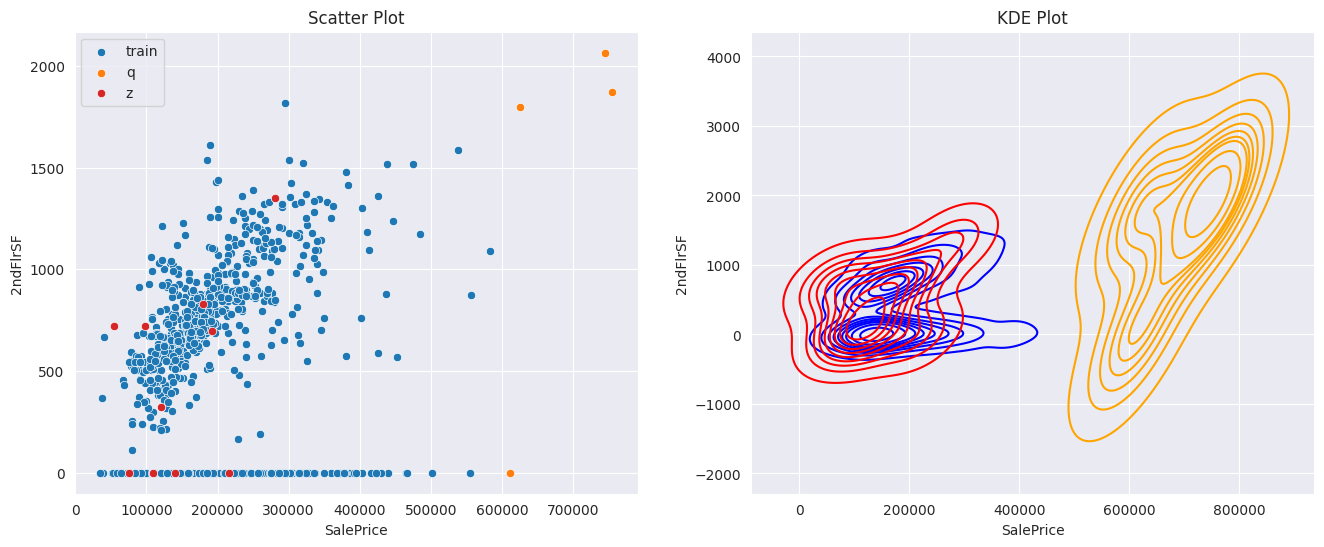

In [155]:
# outliers_z
analyze_outliers(saleprice="SalePrice", arg="2ndFlrSF", quan_1=0.05, quan_3=0.85)

In [164]:
# Handling Missing values
# 2.1 Drop missing values

# 2.2 Impute


# 2.3 Extension to impute

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [267]:
# print(train_df.columns)
# print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20))

ids = [54, 198, 225, 232, 250, 279, 314, 336, 385, 441, 452, 458, 478, 497, 524, 662, 679, 692, 707, 770, 804, 849, 899, 935, 1025, 1047, 1128, 1170, 1183, 1299, 1374, 1397]
# Filter the rows based on the IDs
new_df = train_df.loc[train_df['Id'].isin(ids)]
train_df_filtered = train_df[~train_df['Id'].isin(new_df['Id'])]


train_df_filtered.drop(columns=["BsmtExposure"], inplace=True)
# train_df_filtered.loc[:, "GarageType"] = train_df_filtered["GarageType"].fillna("Attchd")
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20))


AttributeError: 'NoneType' object has no attribute 'loc'

In [261]:
train_df_filtered.drop(columns=["GarageFinish"], inplace=True)
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20))


               0
GarageType    81
GarageCond    81
GarageYrBlt   81
GarageFinish  81
GarageQual    81
BsmtFinType2  38
BsmtExposure  38
BsmtFinType1  37
BsmtCond      37
BsmtQual      37
MasVnrArea     8
Electrical     1
WoodDeckSF     0
PavedDrive     0
LowQualFinSF   0
GrLivArea      0
BsmtFullBath   0
BsmtHalfBath   0
FullBath       0
HalfBath       0


/tmp/ipykernel_8819/4258665749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_filtered.drop(columns=["GarageFinish"], inplace=True)


In [260]:
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20))

train_df_filtered


               0
GarageType    81
GarageCond    81
GarageYrBlt   81
GarageFinish  81
GarageQual    81
BsmtFinType2  38
BsmtExposure  38
BsmtFinType1  37
BsmtCond      37
BsmtQual      37
MasVnrArea     8
Electrical     1
WoodDeckSF     0
PavedDrive     0
LowQualFinSF   0
GrLivArea      0
BsmtFullBath   0
BsmtHalfBath   0
FullBath       0
HalfBath       0


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [206]:
mean
std
min
25
50
75
max

NameError: name 'train_df_filteredmean' is not defined

In [38]:
# Price
Outliers using query
[250, 314, 336, 452, 707, 1299]
Outliers using mean/median
[179, 441, 692, 770, 799, 804, 899, 1047, 1170, 1183]

Outliers using query for MSSubClass 7
[441, 692, 804, 899, 1047, 1170, 1183]

Outliers using query for LotFrontage 7
[441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median LotFrontage 5
[198, 232, 935, 1128, 1299]

Outliers using query for LotArea 7
[441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median LotArea 13
[54, 250, 314, 336, 385, 452, 458, 662, 707, 770, 849, 1299, 1397]

Outliers using query for OverallQual 7
[441, 692, 804, 899, 1047, 1170, 1183]

Outliers using query for BsmtUnfSF 7
[441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median BsmtUnfSF 4
[225, 279, 478, 679]

Outliers using query for 1stFlrSF 7
[441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median 1stFlrSF 5
[497, 524, 1025, 1299, 1374]

Outliers using query for 1stFlrSF 7
[441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median 1stFlrSF 3
[497, 524, 1299]

Outliers using query for 2ndFlrSF 4
[692, 899, 1170, 1183]


SyntaxError: invalid syntax (1967458590.py, line 2)

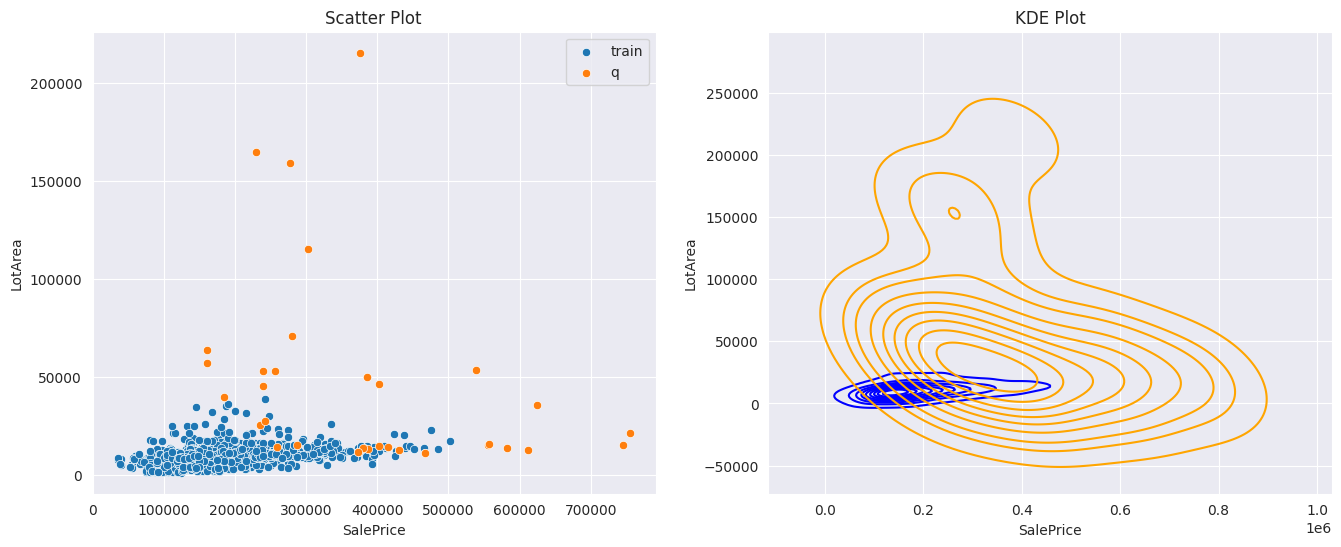

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [156]:
ids = [54, 198, 225, 232, 250, 279, 314, 336, 385, 441, 452, 458, 478, 497, 524, 662, 679, 692, 707, 770, 804, 849, 899, 935, 1025, 1047, 1128, 1170, 1183, 1299, 1374, 1397]


# Filter the rows based on the IDs
new_df = train_df.loc[train_df['Id'].isin(ids)]

# Display the new DataFrame
new_df

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x="SalePrice", y="LotArea", data=train_df, label="train", ax=axes[0])
sns.scatterplot(x="SalePrice", y="LotArea", data=new_df, label="q", ax=axes[0])


# KDE plots
sns.kdeplot(x="SalePrice", y="LotArea", data=train_df, color='blue', ax=axes[1])
sns.kdeplot(x="SalePrice", y="LotArea", data=new_df, color="orange", ax=axes[1])


# Set titles for subplots
axes[0].set_title('Scatter Plot')
axes[1].set_title('KDE Plot')

# Show plots
plt.show()
new_df.columns